# **Installation of Packages**

First install packages like numpy, scikit-learn, matplotlib

In [1]:
!pip3 install numpy 
!pip3 install SPARQLWrapper
!pip3 install scikit-learn
!pip3 install PIL
!pip3 install pandas
!pip3 install webcolors
!pip3 install matplotlib

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


# **Importation of packages**

We import the necessary packages

In [2]:
import os, sys, json
import urllib, shutil
import random, time, webcolors, numpy
import requests
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
from sklearn.cluster import KMeans, MiniBatchKMeans


# **Load Dataset**

In [3]:
endpoint_url = "https://query.wikidata.org/sparql"
img_data = {}

# Requête pour récupérer les infos de l'entité donnée - Q144/Chien par défaut
def query(wd='Q144', limit=5):
    return f"""SELECT ?item ?itemLabel ?pic
                WHERE {{
                  ?item wdt:P31 wd:{wd}.
                  ?item wdt:P18 ?pic.
                  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
                }}
                LIMIT {limit}"""

def get_results(endpoint_url, query):
    user_agent = 'MaximeCornaton/0.0 (https://github.com/MaximeCornaton/CPE_Data_Mining; maxime.cornaton@cpe.fr)'
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    # Boucle de tentative en cas d'erreur 429 Too Many Requests
    for i in range(3):
        try:
            return sparql.query().convert()
        except HTTPError as e:
            if e.response.status_code == 429:
                retry_after = int(e.response.headers.get('Retry-After', '60'))
                print(f"Too Many Requests. Tentative dans {retry_after} secondes.")
                sleep(retry_after)
            else:
                raise e
    
    raise Exception("Nombre maximum de tentatives pour atteindre Wikidata atteint.")

# Pour créer le dossier des images s'il n'existe pas
def createFolder(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print('Dossier '+name+' déjà existant !')

# Pour vérifier si un dossier est vide - évitons de retélécharger des images inutilement.
def isEmpty(name='images'):
    if len(os.listdir(name)) == 0:
        return True
    return False

# Pour ajouter des éléments à la bdd
def addImg(wd, limit):
    results = get_results(endpoint_url, query(wd, limit))
    for result in results['results']['bindings']:
        name_img = result['item']['value'].split("/")[-1] + "-" + wd # nom donné aux images téléchargées "numéro d'image - numéro de catégorie"
        
        #img_data[name_img] = {'image': result['pic']['value']}
        
        img_data[name_img] = {}
        downloadImage(result['pic']['value'], name_img)

# Ajoute les images de toutes les entités spécifiées
def addAllImg(wd, limit):
    for w in wd:
        addImg(w, limit)

# Pour télécharger l'image d'un élément de la bdd
def downloadImage(url, name_img='img0'):
    full_path = 'images/' + name_img + '.jpg'
    urllib.request.urlretrieve(url, full_path)

# Si les images sont déjà téléchargées on initialise le tableau
def initAlreadyDownload(namefolder='images'):
    for image in os.listdir(namefolder):
        #img_data[image.split(".")[0]] = {'image': ""}
        img_data[image.split(".")[0]] = {}


# Pour télécharger toutes les images - limit par query
def downloadAllImages(wd=['Q144'], limit=5):
    createFolder()
    if not isEmpty():
       

        print('Images déjà téléchargées !')
        initAlreadyDownload()
        return False
    addAllImg(wd, limit)
    return True 

#Supprimer une image du dossier 
def removeImage(image):
    if os.path.isfile('images/'+image):
        os.remove('images/'+image)
        img_data.pop(image.split(".")[0])
    else:
        shutil.rmtree('images/'+image)

bdd = ['Q144','Q14660','Q23442','Q28803','Q3305213', 'Q16521', 'Q146', 'Q5', 'Q4022'] #Chien, drapeau, ile, sandwich, peinture, taxon, chat, être humain, riviere
downloadAllImages(wd=bdd,limit=50)
print(img_data)


Dossier images déjà existant !
Images déjà téléchargées !
{'Q86516809-Q144': {}, 'Q97356971-Q144': {}, 'Q958201-Q144': {}, 'Q783490-Q14660': {}, 'Q87783199-Q144': {}, 'Q96176417-Q144': {}, 'Q96372991-Q144': {}, 'Q97280926-Q144': {}, 'Q697098-Q144': {}, 'Q805807-Q144': {}, 'Q73521760-Q144': {}}


# **Adding Meta to the Dataset**

## *1. Exif* 

In [4]:
#Obtenir les metas d'une image
def getMetaImg(name, imgfile):
    #clés Exif
    DATE_KEY = 36867
    MODEL_KEY = 272
    
    img_data[name].update({
        'size': [getSizeImg(imgfile.size), imgfile.size],
        'orientation': getOrientationImg(imgfile.size),
        'format': imgfile.format,
    })
    
    getColorsImg(name, imgfile)
    
    exif_data = imgfile._getexif()
    if exif_data is not None:
        if DATE_KEY in exif_data:
            img_data[name]['date'] = exif_data[DATE_KEY]
        if MODEL_KEY in exif_data:
            img_data[name]['model'] = exif_data[MODEL_KEY]

def getOrientationImg(size): #(largeur,hauteur)
    width,height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"
    
def getSizeImg(size): #(largeur,hauteur)
    width,height = size
    return "large" if width*height>1920*1080 else "small" if width*height<640*480 else "medium"
    


## *2. Main Color* 

In [5]:
def getColorsImg(name, imgfile, cluster_nbr=2, n_init=1):
    
    img_data[name]['colors'] = {}
    
    # Redimensionner l'image pour accélérer le traitement
    imgfile = imgfile.resize((int(imgfile.size[0]/2), int(imgfile.size[1]/2)))

    # Convertir l'image en un tableau numpy
    img_array = numpy.array(imgfile)
    
    try:
        img_vector = img_array.reshape(-1, 3)

        clusters = MiniBatchKMeans(n_clusters=cluster_nbr, n_init=n_init, random_state=0).fit(img_vector) #Random state pour garder la meme seed ppour toutes les images

        for i, center in enumerate(clusters.cluster_centers_):
            rgb = tuple(map(int, center))
            
            # chercher le nom de couleur correspondant au code RGB
            try:
                color_name = webcolors.rgb_to_name(rgb)
            except ValueError:
                # si le nom exact n'est pas trouvé, trouver le nom le plus proche
                min_colors = {}
                for key, name_ in webcolors.CSS3_HEX_TO_NAMES.items():
                    r_c, g_c, b_c = webcolors.hex_to_rgb(key)
                    rd = (r_c - rgb[0]) ** 2
                    gd = (g_c - rgb[1]) ** 2
                    bd = (b_c - rgb[2]) ** 2
                    min_colors[(rd + gd + bd)] = name_
                color_name = min_colors[min(min_colors.keys())]
            

            img_data[name]['colors'][color_name] = rgb
            
    except Exception as e:
        print('Pas de couleur : {}'.format(e))


## *3. All Meta* 

In [6]:
def openImgGetMeta(name): #name = 'img.jpg'
    try:
        with Image.open("images/"+name) as imgfile:
            #print(imgfile.size, imgfile.format)
            name = name.split(".")[0]
            getMetaImg(name, imgfile)

        imgfile.close()
        return True
    except FileNotFoundError as e:
        print('Impossible de trouver le fichier {}: {}'.format("images/"+name, e))
        return False
    except Exception as e:
        print('Erreur lors de l\'ouverture de l\'image {}: {}'.format("images/"+name, e))
        removeImage(name)
        return False
        
#Obtenir les metas de toutes nos images    
def openGetMetaAllImg(namefolder='images'):
    for image in os.listdir(namefolder):
        openImgGetMeta(image)

openGetMetaAllImg()

Pas de couleur : cannot reshape array of size 67760 into shape (3)


## *4. Export to JSON* 

In [7]:
#Enregistre les metadonnées des images dans un JSON
def exportToJSON(data,name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("done")
        
exportToJSON(data=img_data)

done


## *5. Open JSON* 

In [8]:

def openJSON(file="img_data.json"):
    # Ouvrir le fichier JSON en mode lecture (fermé automatiquement)
    with open(file, 'r') as f:
        data = json.load(f)
    return data
    

## *6. Add categories* 

In [9]:
# Requête API à Wikidata pour récupérer les catégories de l'image
def wikidataAPI(_id,lang):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages={lang}&format=json"
    #if lang != "":
    #    #categorie
    #    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels&languages={lang}&format=json"
    #else:
    #    #image
    #    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=claims&format=json"
    response = requests.get(url)
    return json.loads(response.text)


def findTagsImg(_id, lang='en'): #"Q7704028-Q144"
    
    image_id, cat_id = _id.split("-")
    
    # Requête API à Wikidata pour récupérer les catégories de l'image
    img_data = wikidataAPI(image_id,lang)
    cat_data = wikidataAPI(cat_id,lang)
    
    # Extraire le libellé de la catégorie dans la langue souhaitée
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get(lang, {}).get('value', '')
    
    # Trouver les catégories dans la réponse de la requête API sur l'image
    claims = img_data.get("entities", {}).get(image_id, {}).get("claims", {})
    #print([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
    categories = formatCategory([x['mainsnak']['datavalue']['value'] for prop in ["P910", "P373"] for x in claims.get(prop, [])])
            
    if main_tag not in categories:
        categories.append(main_tag)
    
    return categories


def formatCategory(categories):
    categories_ = []
    
    removeCar = ['(', ')']
    splitCar = [',', ' ']
    
    for category in categories:
        if isinstance(category, str):
            for car in removeCar:
                category = category.replace(car, '')
            for car in splitCar:
                parts = category.split(car)
                if len(parts) > 1:
                    categories_.extend(parts[1:])
                    category = parts[0]
            categories_.append(category.lower())
    
    return categories_


def addTagsJSON(image_id = "Q7704028", categories=[]):
    data = openJSON(file="img_data.json")
    data[image_id]['tags'] = categories


def addAllTagsJSON():
    data = openJSON(file="img_data.json")
    for _id in data:
        data[_id]['tags'] = findTagsImg(_id)
    return data


data = addAllTagsJSON()
exportToJSON(data)


done


# **Data Analyses**

## *1. Class User* 

In [10]:
class User:
    def __init__(self, favorite_color=None, favorite_orientation=None, favorite_size=None, favorite_tags=None, favorite_pictures=None):
        self._favorite_color = favorite_color
        self._favorite_orientation = favorite_orientation
        self._favorite_size = favorite_size
        self._favorite_tags = favorite_tags
        self._favorite_pictures = favorite_pictures

    def get_favorite_color(self):
        return self._favorite_color

    def set_favorite_color(self, new_favorite_color):
        self._favorite_color = new_favorite_color

    def get_favorite_orientation(self):
        return self._favorite_orientation

    def set_favorite_orientation(self, new_favorite_orientation):
        self._favorite_orientation = new_favorite_orientation

    def get_favorite_size(self):
        return self._favorite_size

    def set_favorite_size(self, new_favorite_size):
        self._favorite_size = new_favorite_size

    def get_favorite_tags(self):
        return self._favorite_tags

    def set_favorite_tags(self, new_favorite_tags):
        self._favorite_tags = new_favorite_tags

    def get_favorite_pictures(self):
        return self._favorite_pictures

    def set_favorite_pictures(self, new_favorite_pictures):
        self._favorite_pictures = new_favorite_pictures

    def __str__(self):
        return f"User with favorite color {self._favorite_color}, orientation {self._favorite_orientation}, size {self._favorite_size}, tags {self._favorite_tags} and favorite pictures {self._favorite_pictures}"


class RandomUser(User):
    # possible values for each attribute
    colors = list(webcolors.CSS3_HEX_TO_NAMES.values())
    orientations = ["portrait", "landscape", "square"]
    sizes = ["small", "medium", "large"]
    tags = ["nature", "food", "travel", "art", "music", "sports"]

    def __init__(self):
        # call the parent constructor with random parameters
        super().__init__(
            favorite_color=random.sample(self.colors, k=2),
            favorite_orientation=random.choice(self.orientations),
            favorite_size=random.choice(self.sizes),
            favorite_tags=random.sample(self.tags, k=3),
            favorite_pictures=[]
        )


## *2. Creation of random Users* 

In [11]:
#test = RandomUser()
#print(test)

number_users = 10
number_pictures = 5
users = []

for i in range(number_users):
    user = User(favorite_pictures=random.sample(os.listdir("images"), k=number_pictures))
    users.append(user)
    print(user.get_favorite_pictures())


['Q97356971-Q144.jpg', 'Q697098-Q144.jpg', 'Q96372991-Q144.jpg', 'Q805807-Q144.jpg', 'Q97280926-Q144.jpg']
['Q97356971-Q144.jpg', 'Q87783199-Q144.jpg', 'Q805807-Q144.jpg', 'Q96372991-Q144.jpg', 'Q96176417-Q144.jpg']
['Q97280926-Q144.jpg', 'Q783490-Q14660.jpg', 'Q87783199-Q144.jpg', 'Q97356971-Q144.jpg', 'Q96176417-Q144.jpg']
['Q783490-Q14660.jpg', 'Q96372991-Q144.jpg', 'Q805807-Q144.jpg', 'Q73521760-Q144.jpg', 'Q97356971-Q144.jpg']
['Q86516809-Q144.jpg', 'Q783490-Q14660.jpg', 'Q958201-Q144.jpg', 'Q96372991-Q144.jpg', 'Q805807-Q144.jpg']
['Q783490-Q14660.jpg', 'Q96176417-Q144.jpg', 'Q97356971-Q144.jpg', 'Q96372991-Q144.jpg', 'Q73521760-Q144.jpg']
['Q697098-Q144.jpg', 'Q87783199-Q144.jpg', 'Q86516809-Q144.jpg', 'Q783490-Q14660.jpg', 'Q73521760-Q144.jpg']
['Q97280926-Q144.jpg', 'Q697098-Q144.jpg', 'Q805807-Q144.jpg', 'Q73521760-Q144.jpg', 'Q87783199-Q144.jpg']
['Q97356971-Q144.jpg', 'Q958201-Q144.jpg', 'Q805807-Q144.jpg', 'Q97280926-Q144.jpg', 'Q96176417-Q144.jpg']
['Q86516809-Q144.jpg', 

## *3. Analyse Users* 

In [12]:
print(data)

{'Q86516809-Q144': {'size': ['medium', [480, 640]], 'orientation': 'portrait', 'format': 'JPEG', 'colors': {'darkkhaki': [183, 172, 128], 'darkolivegreen': [99, 84, 41]}, 'tags': ['dog', 'néro']}, 'Q97356971-Q144': {'size': ['large', [3264, 2448]], 'orientation': 'landscape', 'format': 'JPEG', 'colors': {'darkkhaki': [197, 168, 121], 'darkslategray': [60, 47, 26]}, 'date': '2013:11:24 15:56:23', 'model': 'iPhone 4S', 'tags': ['dog']}, 'Q958201-Q144': {'size': ['small', [280, 243]], 'orientation': 'landscape', 'format': 'PNG', 'colors': {}, 'tags': ['Nuisance', 'just', 'dog']}, 'Q783490-Q14660': {'size': ['large', [1500, 2310]], 'orientation': 'portrait', 'format': 'JPEG', 'colors': {'darkslategray': [63, 61, 69], 'darkgray': [142, 176, 198]}, 'date': '2016:09:02 15:19:33', 'model': 'X013D', 'tags': ['flag']}, 'Q87783199-Q144': {'size': ['small', [263, 388]], 'orientation': 'portrait', 'format': 'JPEG', 'colors': {'dimgray': [113, 100, 79], 'silver': [207, 195, 167]}, 'tags': ['dog', 't

# **Data Visualization**

## *1. Number of pictures by year* 

{'': 6, '2013:': 1, '2016:': 1, '2010:': 1, '2019:': 1, '2020:': 1}


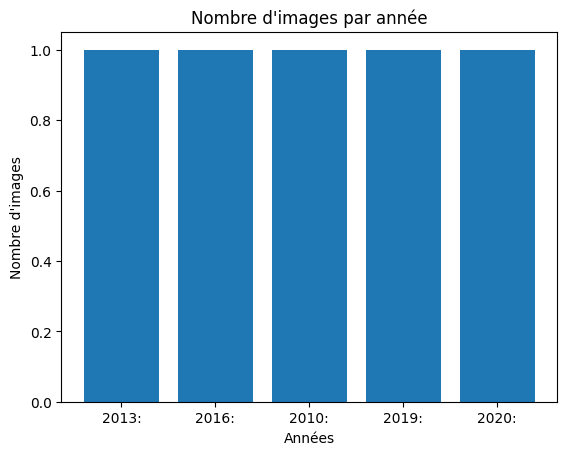

In [13]:
nb_images_year = {}

for image in data:
    date = data[image].get('date', '')[0:5] #Recupere la date de l'image
    nb_images_year[date] = nb_images_year.get(date,0) +1
    
print(nb_images_year)

#Si on veut retirer les images sans date:
nb_images_year.pop('')

noms = list(nb_images_year.keys())
valeurs = list(nb_images_year.values())

plt.bar(noms, valeurs)
plt.title("Nombre d'images par année")
plt.xlabel("Années")
plt.ylabel("Nombre d'images")
plt.show()

## *2. Number* 

# **Recommendation System**
